In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('apw-notebook.mplstyle')
%matplotlib inline
import emcee
import corner

# for reproducibility
np.random.seed(42)

Simulated, repeat observations of the flux of a star:

In [2]:
true_Q = 0.125
true_flux = 1.
true_outlier_std = 1.

In [3]:
n_data = 32
time = np.linspace(0, 100., n_data) # over 100 days, say

flux_err = np.random.uniform(0.04, 0.1, n_data)
flux = np.random.normal(true_flux, flux_err)

outlier_idx = np.random.choice(n_data, size=int(true_Q*n_data), replace=False)
flux[outlier_idx] = np.random.uniform(1, 4, size=len(outlier_idx))

<Container object of 3 artists>

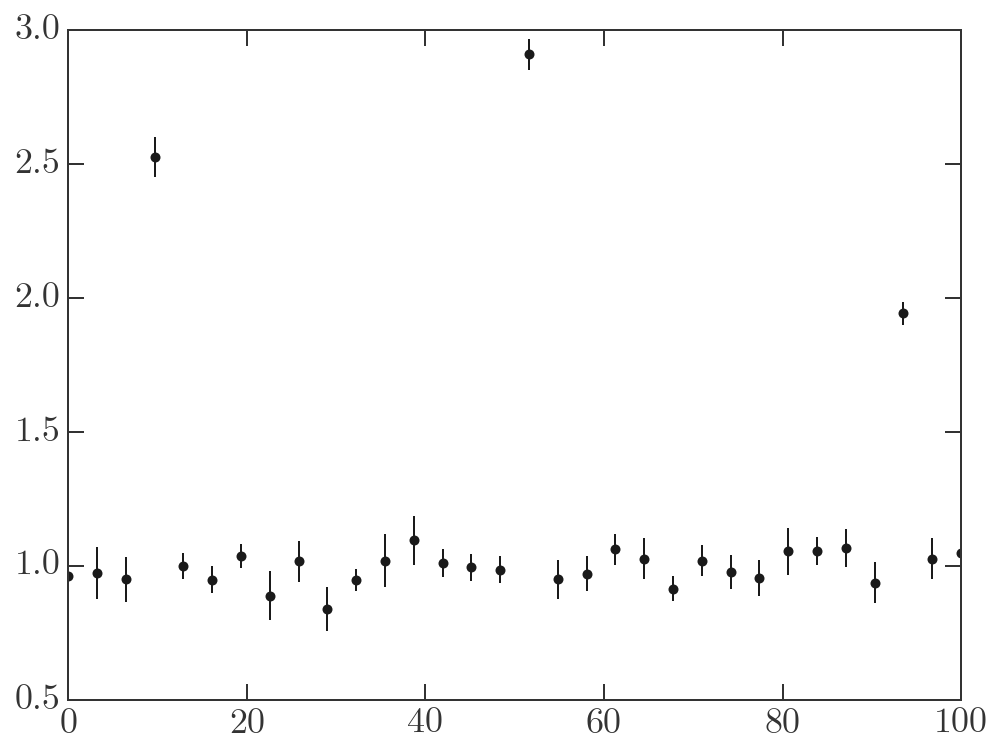

In [4]:
plt.figure(figsize=(8,6))
plt.errorbar(time, flux, flux_err, 
             linestyle='none', marker='o')

In [5]:
np.sum(flux/flux_err)/np.sum(1/flux_err)

1.1371328794611186

In [6]:
def ln_prior(p):
    mean_flux, Q, out_mu, out_lnV = p
    
    # uniform prior over some ranges
    
    if mean_flux < 0 or mean_flux > 100:
        return -np.inf
    
    if Q < 0 or Q > 1:
        return -np.inf
    
    return 0.
    
def ln_likelihood(p, flux, flux_err):
    mean_flux, Q, out_mu, out_lnV = p
    
    # the outlier likelihood:
    var = flux_err**2 + np.exp(out_lnV)
    ll_out = -0.5 * ((out_mu - flux)**2/var + np.log(var))
    
    # the inlier likelihood:
    ll_in = -0.5 * (((mean_flux - flux)/flux_err)**2 + 2*np.log(flux_err))

    # Combine these using log-add-exp for numerical stability.
    ll = np.sum(np.logaddexp(ll_out + np.log(Q), 
                             ll_in + np.log(1-Q)))
    
    return ll

def ln_posterior(p, flux, flux_err):
    
    # short-circuit if the prior is infinite (don't bother computing likelihood)
    lnp = ln_prior(p)
    if np.isinf(lnp): 
        return lnp

    lnL = ln_likelihood(p, flux, flux_err)
    lnprob = lnp + lnL

    if np.isnan(lnprob):
        return -np.inf

    return lnprob

In [7]:
n_walkers = 16
n_dim = 4
sampler = emcee.EnsembleSampler(n_walkers, n_dim, ln_posterior, args=(flux,flux_err))

In [8]:
p0 = [1., 0.5, 0., 0.]
p0 = emcee.utils.sample_ball(p0, np.full_like(p0, 1E-3), size=n_walkers)

pos,_,_ = sampler.run_mcmc(p0, 1024)
sampler.reset()
_ = sampler.run_mcmc(pos, 4096)

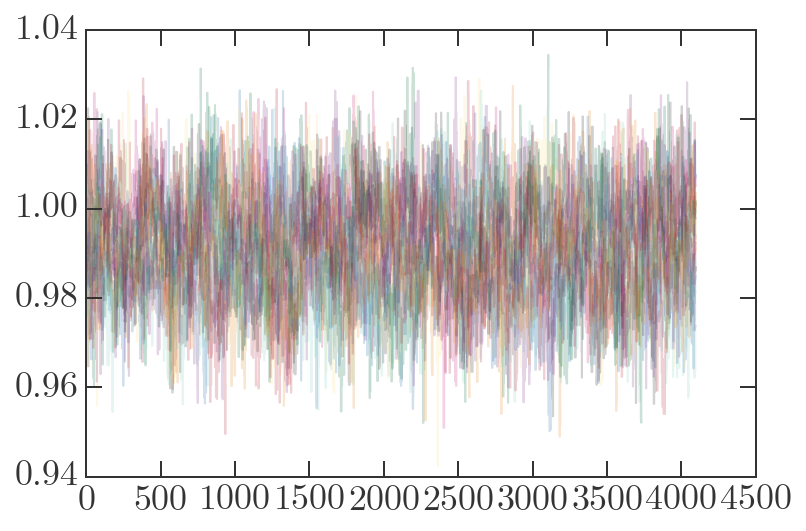

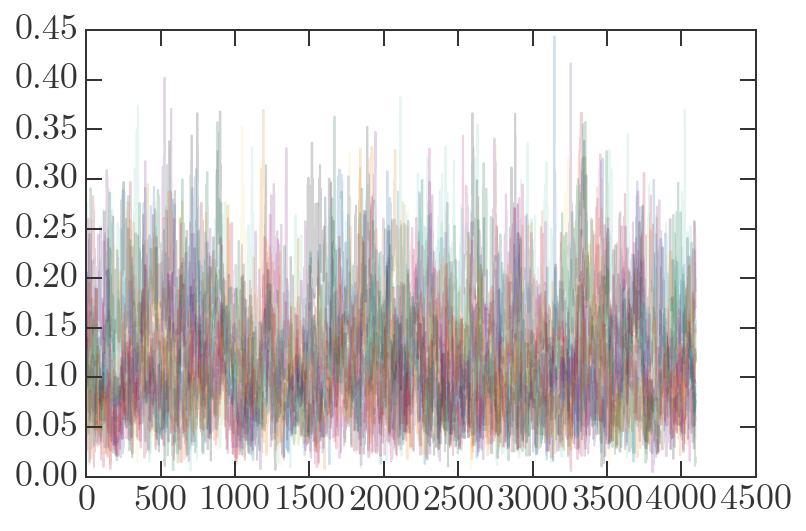

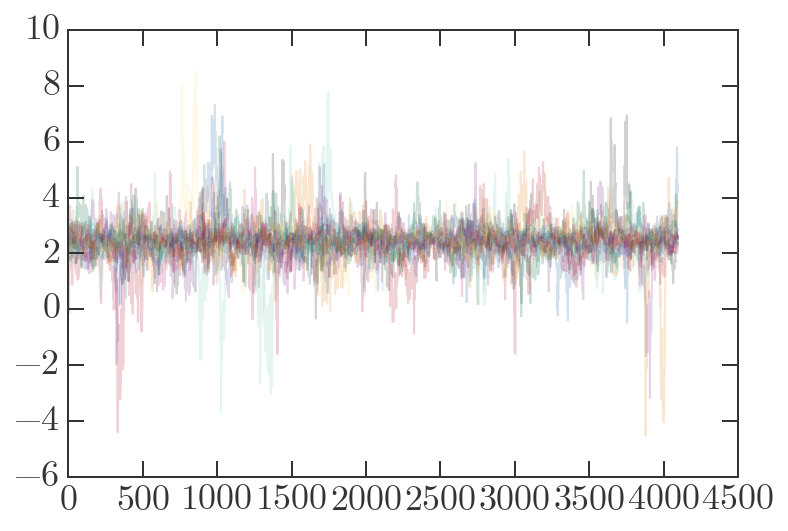

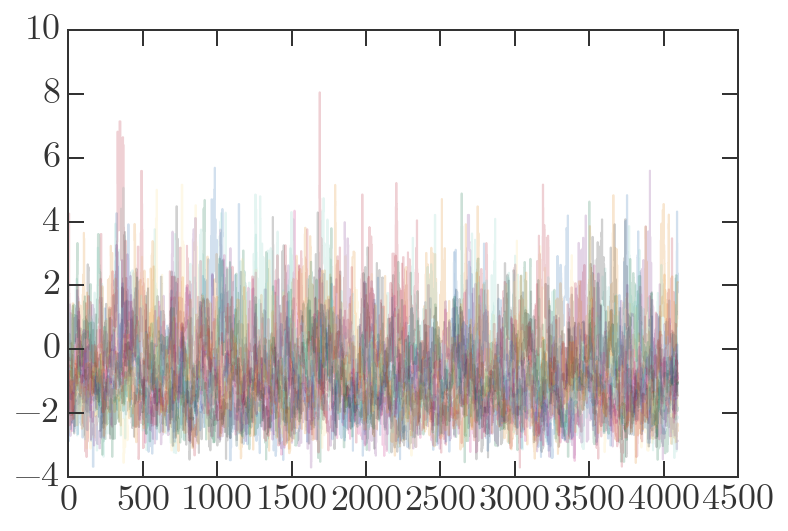

In [9]:
for k in range(sampler.chain.shape[-1]):
    plt.figure()
    
    for walker in sampler.chain[...,k]:
        plt.plot(walker, drawstyle='steps-mid', marker='', alpha=0.2)

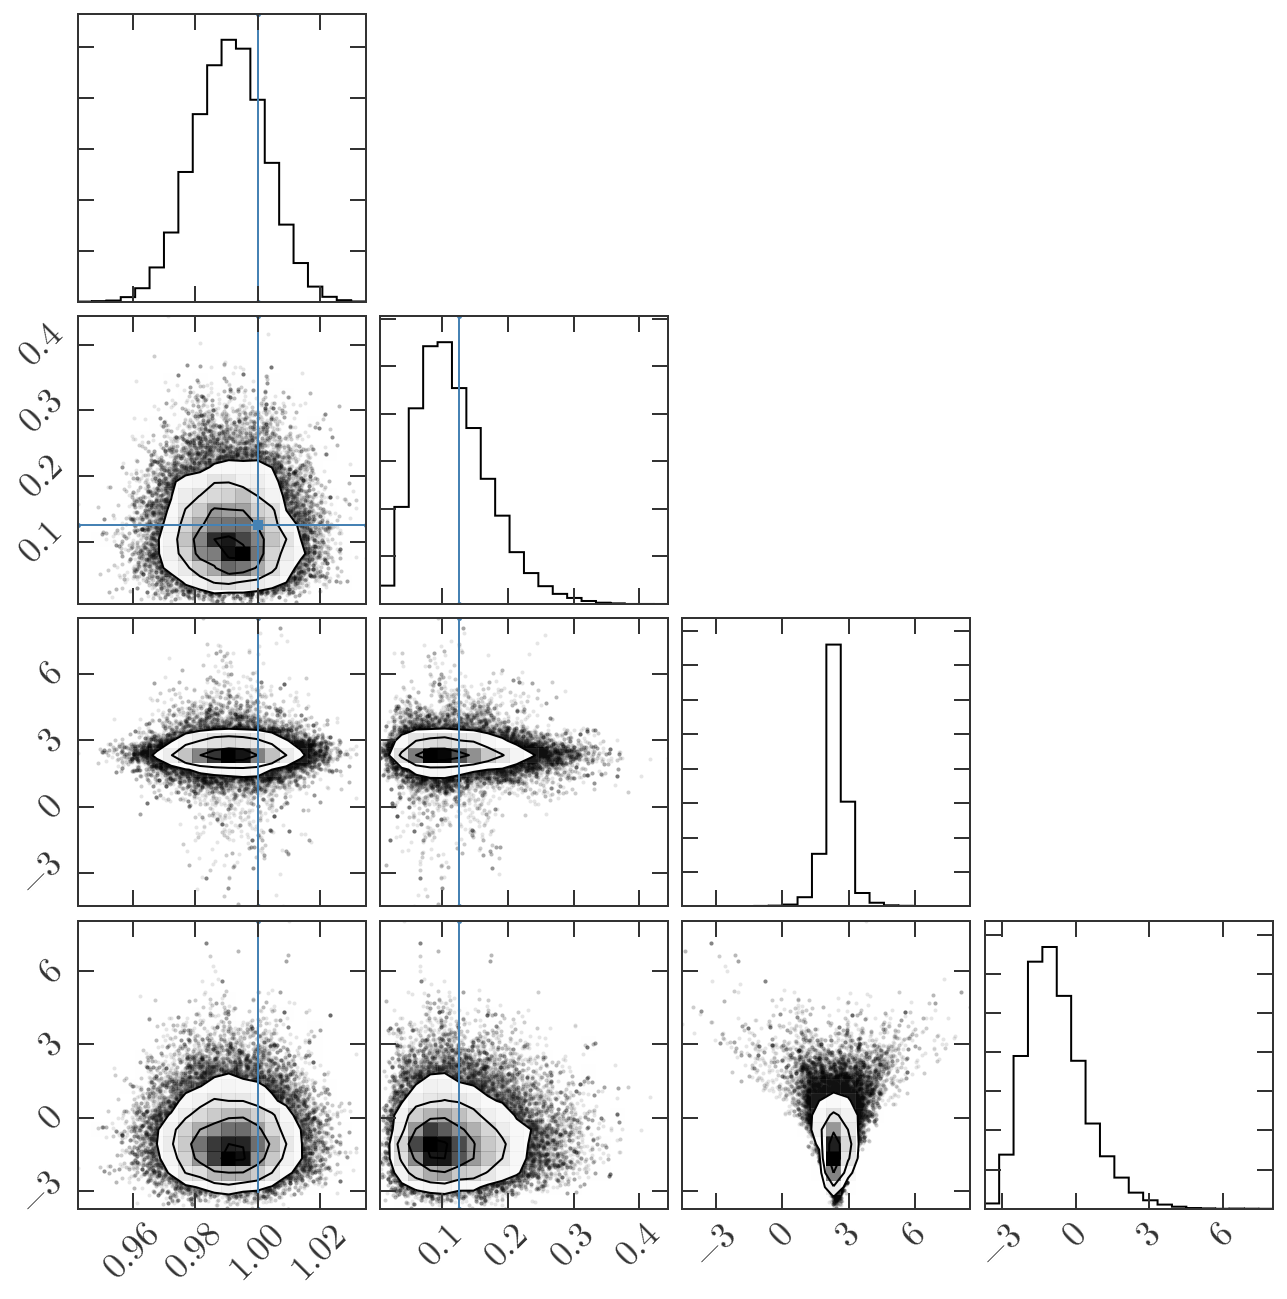

In [10]:
_ = corner.corner(sampler.flatchain, truths=[true_flux, true_Q, np.nan, np.nan])